In [1]:
import numpy as np 
import pandas as pd
import pymap3d as pm
import pickle
import matplotlib.pyplot as plt 

from controller import DisturbanceRejectionController

In [2]:
# Preprocess an entire file to be fed into our model
def process_file(filename):
    data_load_try = []

    with open(filename, "rb") as file:
        try:
            while True:
                data_load_try.append(pickle.load(file))
        except:
            pass 

    df = pd.DataFrame(data_load_try)
    next_wps = []
    for wp in df['remaining_waypoints']:
        next_wps.append(wp[0])

    df['next_wps'] = next_wps
    df = df.drop('remaining_waypoints', axis=1)
    xy_np = pm.ecef2enu(df['ecefx'].astype(float), df['ecefy'].astype(float), df['ecefz'].astype(float), df['lat'].astype(float)[0], df['lon'].astype(float)[0], 0)
    xy_np = np.array(xy_np).T
    df['x'] = xy_np[:,0]
    df['y'] = xy_np[:,1]
    df['next_wps'] = df['next_wps'].apply(tuple)
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    
    wps = np.array(df['next_wps'].tolist())
    xwp, ywp, zwp = pm.geodetic2enu(wps[:,0], wps[:,1], wps[:,2], df['lat'].astype(float)[0], df['lon'].astype(float)[0], 0)
    df['xwp'] = xwp 
    df['ywp'] = ywp 
    df['zwp'] = wps[:,2] + 125 # seems off by a bit, temporary correction

    vxy_np = pm.ecef2enuv(df['vEcefx'].astype(float), df['vEcefy'].astype(float), df['vEcefz'].astype(float), df['lat'].astype(float)[0], df['lon'].astype(float)[0], deg=True)
    vxy_np = np.array(vxy_np).T
    df['vx'] = vxy_np[:,0]
    df['vy'] = vxy_np[:,1]
    df['vz'] = vxy_np[:,2]

    return df

In [3]:
# Data from Luis
filepath = '../../wind-estimation-control/src/data/luis_wind/e_shape_no_wind.pkl'

data = process_file(filepath)

In [4]:
data.columns

Index(['lon', 'lat', 'ecefx', 'ecefy', 'ecefz', 'vEcefx', 'vEcefy', 'vEcefz',
       'alt', 'trackNumber', 'hdg', 'time_boot_ms', 'roll', 'pitch', 'yaw',
       'rollspeed', 'pitchspeed', 'yawspeed', 'next_wps', 'x', 'y', 'xwp',
       'ywp', 'zwp', 'vx', 'vy', 'vz'],
      dtype='object')

In [5]:
starting_pos = np.array([data['x'][0], data['y'][0], float(data['alt'][0])])
controller = DisturbanceRejectionController(starting_pos, True)

In [6]:
all_waypoints = np.unique(np.vstack([data['xwp'], data['ywp'], data['zwp']]).T, axis=1)

In [7]:
ref_vels = []
delta_vels = []

for index, row in data.iterrows():
    pos = np.array([row['x'], row['y'], float(row['alt'])])
    vel = np.array([row['vx'], row['vy'], row['vz']])
    eul = np.array([row['roll'], row['pitch'], row['yaw']], dtype=np.float32)
    rates = np.array([row['rollspeed'], row['pitchspeed'], row['yawspeed']], dtype=np.float32)
    next_wp = np.array([row['xwp'], row['ywp'], row['zwp']])

    next_wp_index = np.where(np.all(np.isclose(all_waypoints, next_wp), axis=1))[0][0]
    if next_wp_index == 0:
        prev_wp = starting_pos
    else:
        prev_wp = all_waypoints[next_wp_index-1]
        
    next_wp = all_waypoints[next_wp_index]
    ref_vel, delta_vel = controller.control(pos, vel, eul, rates, next_wp, prev_wp)

    ref_vels.append(ref_vel)
    delta_vels.append(delta_vel)

In [8]:
ref_vels = np.array(ref_vels)
delta_vels = np.array(delta_vels)

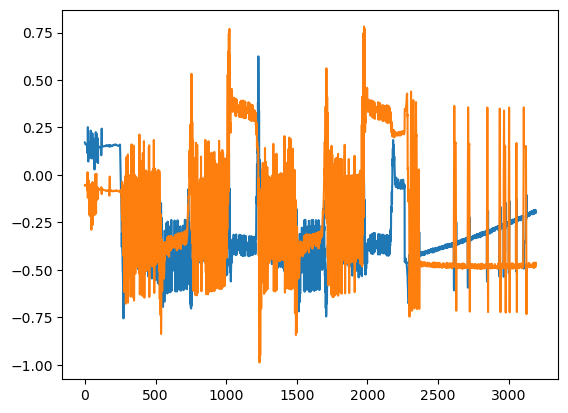

In [9]:
plt.plot(delta_vels[:,0])
plt.plot(delta_vels[:,1])

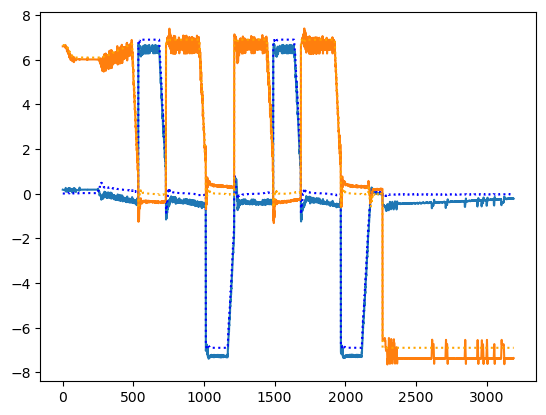

In [10]:
plt.plot(ref_vels[:,0] + delta_vels[:,0])
plt.plot(ref_vels[:,0], linestyle=':', color='blue')
plt.plot(ref_vels[:,1] + delta_vels[:,1])
plt.plot(ref_vels[:,1], linestyle=':', color='orange')

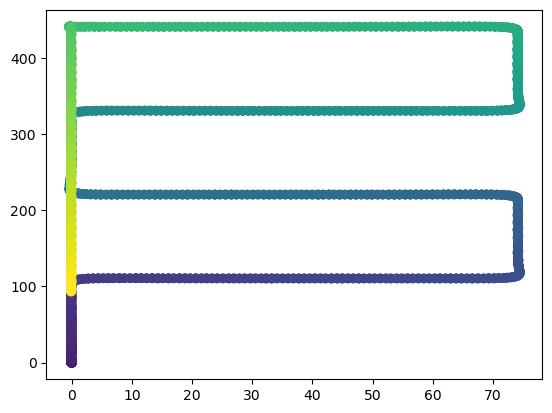

In [11]:
plt.scatter(data['x'], data['y'], c=range(len(data)))